### Paper referred to
https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import torch
import torch.nn.functional as F
from sklearn.model_selection import train_test_split

In [2]:
df = pd.read_csv("./Indian_Names.csv")
df.dropna(inplace=True)
df.head()

,Unnamed: 0,Name
0,0,aabid
1,1,aabida
2,2,aachal
3,3,aadesh
4,4,aadil


In [3]:
names = df["Name"].values
names = [i for i in names if i.isalpha()]
names[:9]

['aabid',
 'aabida',
 'aachal',
 'aadesh',
 'aadil',
 'aadish',
 'aaditya',
 'aaenab',
 'aafreen']

In [4]:
chars = sorted(list(set("".join(names))))
stoi = {s: i + 1 for i, s in enumerate(chars)}
stoi["."] = 0
itos = {i: s for s, i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [5]:
# building the dataset for the network

blockSize = 3 # the size of the context to be considered for predicting the next character
X, y = [], []

for n in names:
    # print(n)
    context = [0] * blockSize
    for ch in n + ".":
        idx = stoi[ch]
        X.append(context)
        y.append(idx)
        # print("".join(itos[i] for i in context), "-->", itos[idx])
        context = context[1:] + [idx]

X = torch.tensor(X)
y = torch.tensor(y)

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.111, random_state=42) # 0.111 x 0.9 = 0.1

In [7]:
X_train.shape, y_train.shape # dataset

(torch.Size([38052, 3]), torch.Size([38052]))

In [8]:
C = torch.randn((27, 10), requires_grad=True) # embedding table in 2 dimensions
emb = C[X_train]

# first layer of neurons
W1 = torch.randn((30, 200), requires_grad=True)
b1 = torch.randn(200, requires_grad=True)

# second hidden layer of neurons
h = torch.tanh(emb.view(-1, 30) @ W1 + b1)

# third (utput) layer of neurons
W2 = torch.randn((200, 27), requires_grad=True)
b2 = torch.randn(27, requires_grad=True)

parameters = [C, W1, b1, W2, b2]

In [9]:
sum(p.nelement() for p in parameters) # total number of parameters

11897

In [10]:
steps = []
lossesTrain = []
lossesVal = []

In [11]:
for i in range(30000):

    # constructing the mini batch
    idx = torch.randint(0, X_train.shape[0], (256, ))

    # forward pass
    emb = C[X_train[idx]]
    h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
    logits = h @ W2 + b2
    loss_train = F.cross_entropy(logits, y_train[idx])

    emb = C[X_val]
    h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
    logits = h @ W2 + b2
    loss_val = F.cross_entropy(logits, y_val)

    # backward pass
    for p in parameters:
        p.grad = None
    loss_train.backward()
    # update
    lr = 0
    if i < 10000:
        lr = 0.1
    elif i > 10000 and i < 20000:
        lr = 0.01
    else:
        lr = 0.001
    for p in parameters:
        p.data += -lr * p.grad
    
    steps.append(i)
    lossesTrain.append(loss_train.item())
    lossesVal.append(loss_val.item())

print(loss_train.item()) # mini batch loss

2.0846714973449707


In [12]:
# further training by decaying lr further

for i in range(10000):

    # constructing the mini batch
    idx = torch.randint(0, X_train.shape[0], (256, ))

    # forward pass
    emb = C[X_train[idx]]
    h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
    logits = h @ W2 + b2
    loss_train = F.cross_entropy(logits, y_train[idx])

    emb = C[X_val]
    h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
    logits = h @ W2 + b2
    loss_val = F.cross_entropy(logits, y_val)

    # backward pass
    for p in parameters:
        p.grad = None
    loss_train.backward()
    # update
    lr = 0.0001
    for p in parameters:
        p.data += -lr * p.grad
    
    steps.append(i)
    lossesTrain.append(loss_train.item())
    lossesVal.append(loss_val.item())

print(loss_train.item()) # mini batch loss

2.0508482456207275


In [13]:
emb = C[X_train]
h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, y_train)
print(loss.item()) # final training loss

2.113219976425171


In [14]:
emb = C[X_val]
h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, y_val)
print(loss.item()) # final validation loss

2.31799054145813


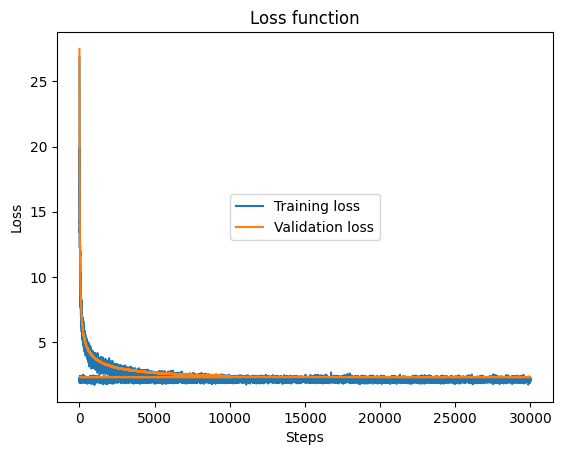

In [15]:
plt.plot(steps, lossesTrain, label="Training loss")
plt.plot(steps, lossesVal, label="Validation loss")
plt.title("Loss function")
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.legend(loc="center")

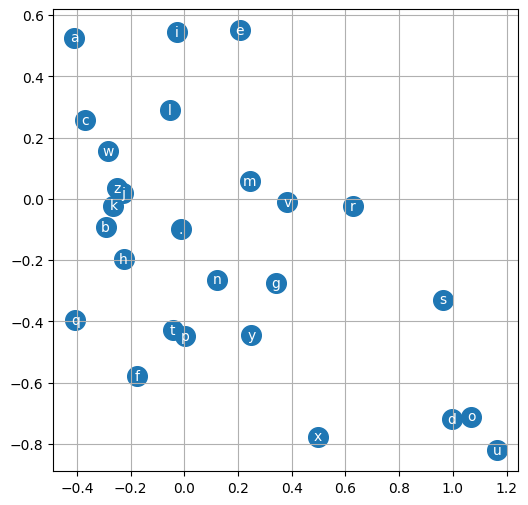

In [16]:
# visualize dimensions 0 and 1 of the embedding matrix C for all characters
plt.figure(figsize=(6, 6))
plt.scatter(C[:, 0].data, C[:, 1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i, 0].item(), C[i, 1].item(), itos[i], ha="center", va="center", color="white")
plt.grid("minor")

In [17]:
# sample from the model

for _ in range(20):
    
    out = []
    context = [0] * blockSize # initialize with all ...
    while True:
      emb = C[torch.tensor([context])] # (1, blockSize, d)
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      idx = torch.multinomial(probs, num_samples=1, ).item()
      context = context[1:] + [idx]
      out.append(idx)
      if idx == 0:
        break
    
    print("".join(itos[i] for i in out))

kay.
amar.
miti.
rub.
javeeramercya.
sir.
imarpia.
parveela.
joginkki.
asnsh.
mimaufbari.
shak.
sakfarmaanta.
neem.
ifakji.
shandu.
ram.
kin.
pulpe.
silcy.
